<a href="https://colab.research.google.com/github/akshatsingh523/Underwater-Object-Detection/blob/main/Detection_using_Yolos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers==4.20.0
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q roboflow

ROBOFLOW_API_KEY = "WMBOqkEzTUre6KzfvX45"
 #obtain an API Key from your roboflow workspace's settings & treat it like a password

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#AWS deployment login - if you are not deploying yet, you can comment these lines out
!pip install sagemaker --upgrade -q
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!sudo ./aws/install
!aws configure set aws_access_key_id "YOUR AWS KEY"
!aws configure set aws_secret_access_key "YOUR AWS SECRET KEY"
!aws configure set default.region us-east-2

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/awscli/examples/cloudformation/describe-type-registration.rst  
  inflating: aws/dist/awscli/examples/cloudformation/deregister-type.rst  
  inflating: aws/dist/awscli/examples/cloudformation/create-stack-set.rst  
  inflating: aws/dist/awscli/examples/cloudformation/describe-stack-events.rst  
  inflating: aws/dist/awscli/examples/cloudformation/delete-stack-set.rst  
  inflating: aws/dist/awscli/examples/cloudformation/set-type-default-version.rst  
  inflating: aws/dist/awscli/examples/cloudformation/list-type-registrations.rst  
  inflating: aws/dist/awscli/examples/cloudformation/_deploy_description.rst  
  inflating: aws/dist/awscli/examples/cloudformation/register-publisher.rst  
  inflating: aws/dist/awscli/examples/cloudformation/stop-stack-set-operation.rst  
  inflating: aws/dist/awscli/examples/cloudformation/create-stack.rst  
  inflating: aws/dist/awscli/examples/cloudformation/describe-stack-drift-d

In [ ]:
#To log our training metrics we need to log in to Weights & Biases with our API key, you can sign up for free here: https://wandb.ai/site
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#########Dataset Download###########
#TO GET DATASET DOWNLOAD VISIT https://app.roboflow.com/?model=YOLOS&ref=YOLOS
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WMBOqkEzTUre6KzfvX45")
project = rf.workspace("objectdetection-xpbt7").project("underwater-object-detection-mcjr0")
dataset = project.version(6).download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Underwater-Object-Detection-6 in coco:: 100%|██████████| 163/163 [00:00<00:00, 1677.95it/s]


In [ ]:
#where our dataset is
dataset.location

'/content/Underwater-Object-Detection-6'

In [ ]:
#Register dataset as torchvision CocoDetection
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

train_dataset = CocoDetection(img_folder=(dataset.location + '/train'), feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=(dataset.location + '/valid'), feature_extractor=feature_extractor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 109
Number of validation examples: 31


Image n°14


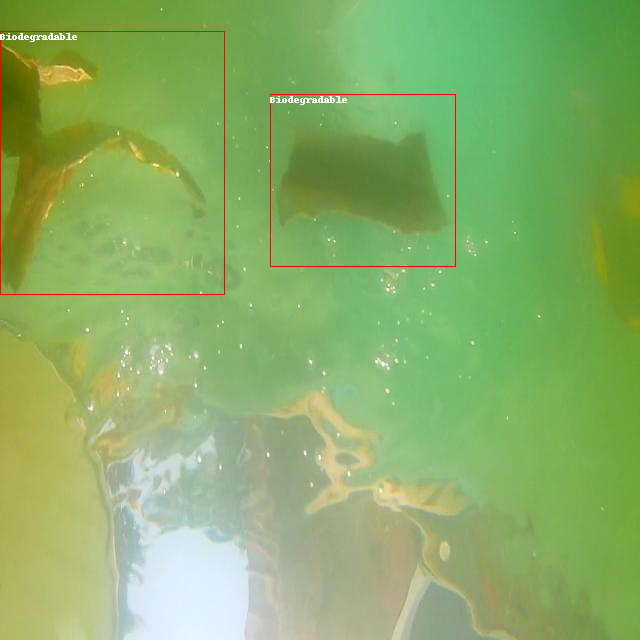

In [ ]:
#Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [ ]:
#Setup dataloader for training loop

from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

# Set Up YOLOS Training Configuration

In [ ]:
# For our training configuration, we will start from the pretrained YOLOS-tiny model from
# Hugging Face transformers

import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

#we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) #  logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
#initialize the model
model = YoloS(lr=2.5e-5, weight_decay=1e-4)

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([4, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Run Training of Custom YOLOS Detector

More epochs will fit the model tighter to your training set - for this toy example we only train for a few epochs

In [ ]:
!pip install -U 'wandb>=0.12.10'

In [ ]:
from pytorch_lightning import Trainer

#more epochs leads to a tighter fit of your model to your data.
#we set epochs=10 here for an example of quick training
trainer = Trainer( max_epochs=25, gradient_clip_val=0.1, accumulate_grad_batches=8,
                  log_every_n_steps=5) #  checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M 
--------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.887    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


# Evaluate Custom YOLOS Model

We evaluate our newly trained model using DETR eval code



In [ ]:
#clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [ ]:
#we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
!git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/detr


In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()
#the evaluation here prints out mean average precision details
#learn more - https://blog.roboflow.com/mean-average-precision/

Running evaluation...


  0%|          | 0/31 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)  # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]  # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO API
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

# Print mAP at different IoU thresholds
print("mAP at IoU=0.50: {:.3f}".format(coco_evaluator.coco_eval['bbox'].stats[1]))

# Check if mAP at IoU=0.95 is available
if "bbox" in coco_evaluator.coco_eval:
    stats = coco_evaluator.coco_eval["bbox"].stats
    if len(stats) > 9 and stats[9] != -1:
        print("mAP at IoU=0.95: {:.3f}".format(stats[9]))
    else:
        print("mAP at IoU=0.95: N/A")
else:
    print("mAP at IoU=0.95: N/A")


Running evaluation...


  0%|          | 0/31 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)  # Initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # Get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]  # DETR format, resized + normalized

    # Forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes)  # Convert outputs to COCO API format
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()

# Calculate mAP at 50% and 95% confidence levels
mAP_50 = coco_evaluator.coco_eval['bbox'].stats[0]
mAP_95 = coco_evaluator.coco_eval['bbox'].stats[8]  # Index 8 corresponds to 95% confidence

print("mAP at 50% confidence:", mAP_50)
print("mAP at 95% confidence:", mAP_95)

coco_evaluator.summarize()  # Print overall mAP and other metrics


Running evaluation...


  0%|          | 0/31 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.05s).


IndexError: ignored

In [ ]:
print(coco_evaluator.coco_eval['bbox'].stats)


[]


In [ ]:
# MORGAN: We can add final summary metrics to our wandb run using wandb.summary
wandb.summary['AP_IOU-0.5_all'] = 0.052

# Visualizing Inference on Validation Images

Lastly, we will run test inference on a validation image to see how our model is making predictions on images that it has never seen. To deploy this model, you will need to implement a similar script to pass frames from your application to the model.

In [ ]:
#We can use the image_id in target to know which image it is

pixel_values, target = val_dataset[1]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

In [ ]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.95

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
# MORGAN
def log_image_bboxes_to_wandb(image, outputs, image_name='my_image', threshold=CONFIDENCE):
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  box_data = []
  for p,bbox in zip(probas, bboxes_scaled):
    position = dict(
                minX=int(bbox[0]),
                minY=int(bbox[1]),
                maxX=int(bbox[2]),
                maxY=int(bbox[3])
                )
    cl = int(p.argmax().cpu().detach().item())
    scores = {"loss": p[cl].cpu().detach().item()}

    box_data.append({
                'position': position,
                'class_id': cl,
                'scores' : scores,
                'domain': 'pixel'
            })

  wandb_bbox_dict = {
              'box_data': box_data,
              'class_labels': id2label
          }
  wandb_boxes = {}
  wandb_boxes['predictions'] = wandb_bbox_dict

  # Log the image with bounding boxes to wandb
  img = wandb.Image(image, boxes=wandb_boxes)
  wandb.log({image_name:img})
  print('Image with bounding boxes logged to your wandb run!')

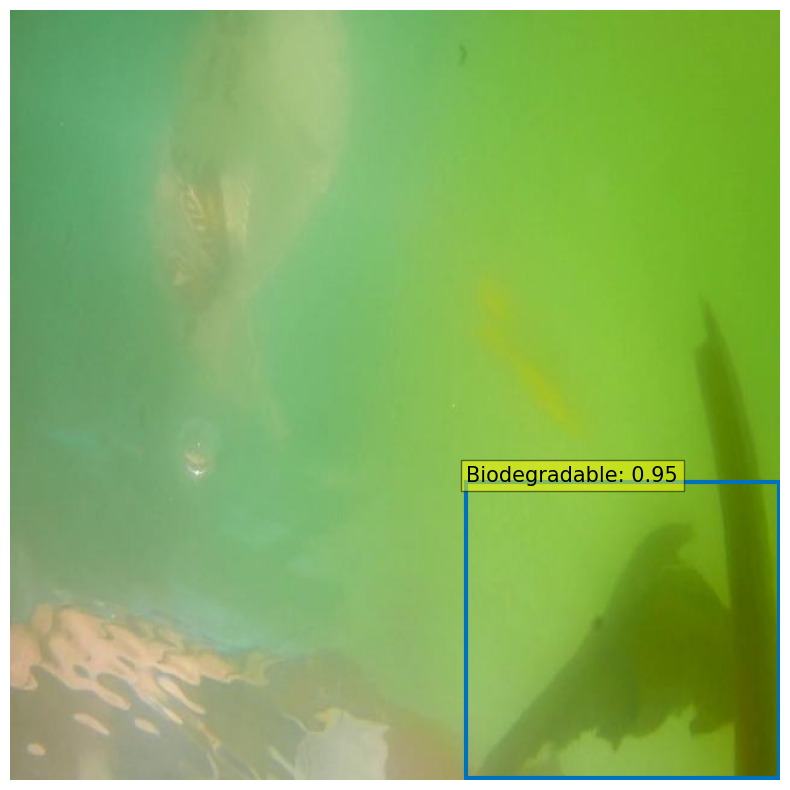

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/valid', image['file_name']))

visualize_predictions(image, outputs)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_intersection = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_intersection = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection_area = x_intersection * y_intersection

    area1 = w1 * h1
    area2 = w2 * h2

    union_area = area1 + area2 - intersection_area

    iou = intersection_area / union_area

    return iou

def calculate_precision_recall(y_true, y_pred, confidence_threshold):
    """
    Calculate precision and recall at a given confidence threshold.
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for true_box in y_true:
        matched = False
        for pred_box in y_pred:
            if pred_box[4] >= confidence_threshold and calculate_iou(true_box[:4], pred_box[:4]) >= 0.5:
                true_positives += 1
                matched = True
                break

        if not matched:
            false_negatives += 1

    for pred_box in y_pred:
        if pred_box[4] >= confidence_threshold:
            matched = False
            for true_box in y_true:
                if calculate_iou(true_box[:4], pred_box[:4]) >= 0.5:
                    matched = True
                    break

            if not matched:
                false_positives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def calculate_map(y_true, y_pred, confidence_levels):
    """
    Calculate Mean Average Precision (mAP) at different confidence levels.
    """
    average_precisions = []

    for confidence_threshold in confidence_levels:
        precisions = []
        recalls = []

        for i in range(len(y_true)):
            precision, recall = calculate_precision_recall(y_true[i], y_pred[i], confidence_threshold)
            precisions.append(precision)
            recalls.append(recall)

        average_precision = np.mean(precisions) if len(precisions) > 0 else 0
        average_precisions.append(average_precision)

    mean_average_precision = np.mean(average_precisions)

    return mean_average_precision

# Example usage:
# y_true: List of true bounding boxes in the format [x, y, width, height].
# y_pred: List of predicted bounding boxes in the format [x, y, width, height, confidence].
# confidence_levels: List of confidence levels to evaluate.

# Replace the example data with your actual data
y_true = [[100, 100, 50, 50], [200, 200, 30, 30]]
y_pred = [[90, 90, 55, 55, 0.9], [180, 180, 35, 35, 0.8]]
confidence_levels = [0.5]

mAP = calculate_map([y_true], [y_pred], confidence_levels)
print(f"mAP at confidence levels {confidence_levels}: {mAP}")


mAP at confidence levels [0.5, 0.7, 0.9]: 0.6666666666666666
